In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
import math
import mlflow
from mlflow.models.signature import infer_signature

In [2]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
min_max_scaler = MinMaxScaler()
standar_scaler = StandardScaler()
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng)

In [3]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

def porcentaje_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((data < BI) | (data > BS))
    print("Porcentaje de outliers: ", 100*out.sum()/out.count())

def quitar_outliers(data, df_feature):
    Q1 = df_feature.quantile(0.25)
    Q3 = df_feature.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((df_feature > BI) & (df_feature < BS))
    data = data.loc[out]
    return data

In [7]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')
df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [9]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
#Eliminar signo de interrogación de modelo y calcular valores únicos
df.Model = df.Model.apply(lambda x: x.replace('?', ''))
print("Valores únicos de modelos: ",len(df.Model.value_counts()))

Valores únicos de modelos:  319


In [11]:
#Encoder Fuel Type
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [12]:
drop_columns = ['Model', 'Id', 'Cylinders']

In [13]:
df = df.drop(columns=drop_columns)

#### Definir x e y

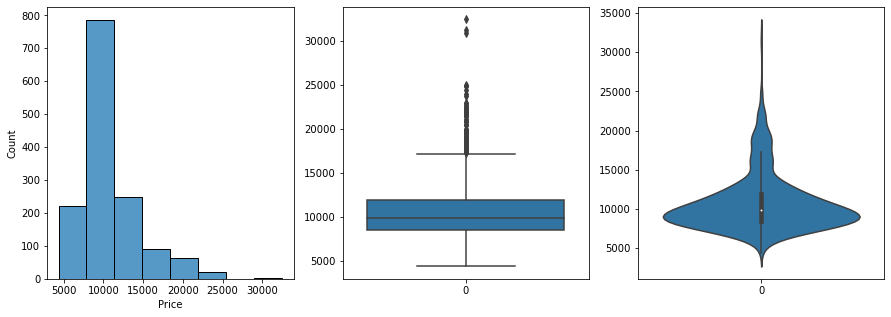

In [14]:
graficar_info_variable(df.Price)

In [15]:
porcentaje_outliers(df.Price)

Porcentaje de outliers:  7.66016713091922


In [16]:
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  4.30188679245283


In [17]:
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  0.0


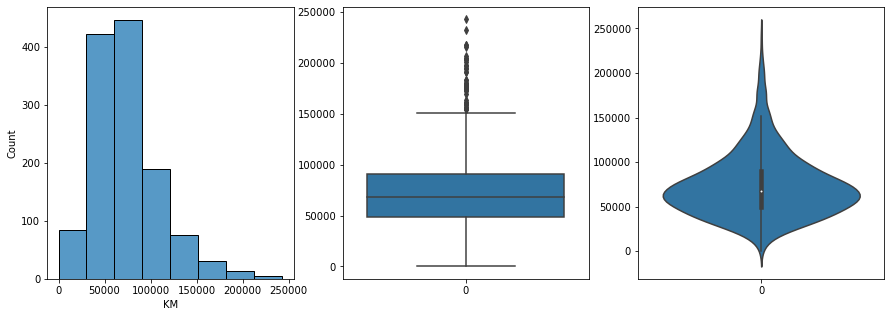

In [18]:
graficar_info_variable(df.KM)

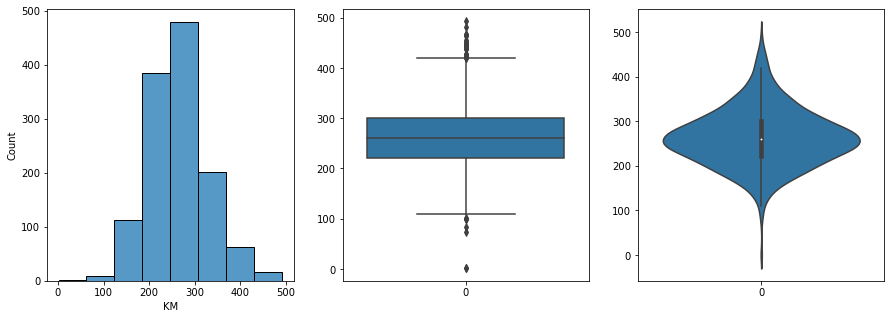

In [19]:
df.KM = np.sqrt(df.KM)
graficar_info_variable(df.KM)

In [20]:
porcentaje_outliers(df.KM)

Porcentaje de outliers:  2.6025236593059935


In [21]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.48582995951417


In [22]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.0


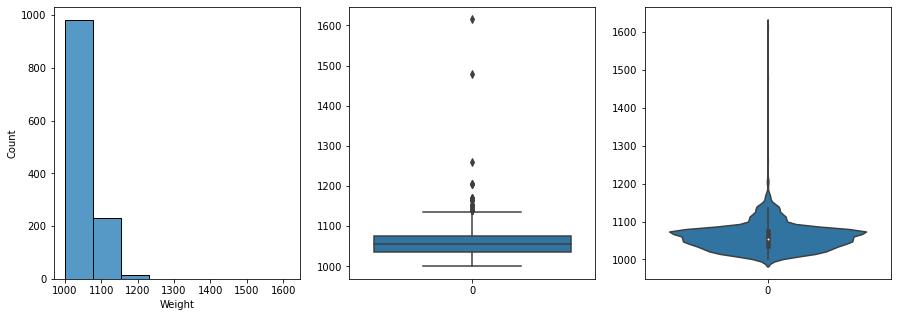

In [23]:
graficar_info_variable(df.Weight)

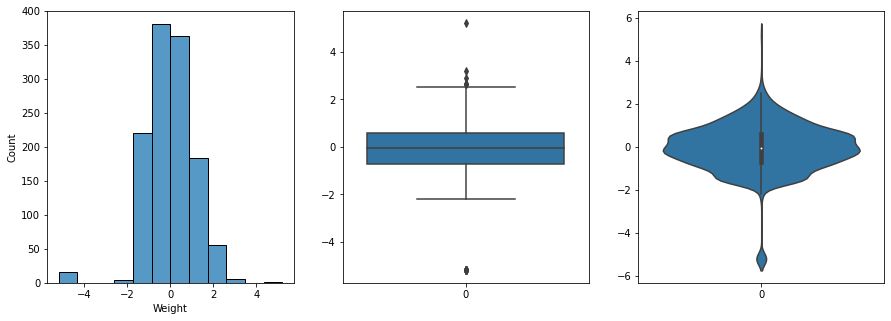

In [24]:
df.Weight = qt.fit_transform(df.Weight.values.reshape(-1, 1))
graficar_info_variable(df.Weight, 12)

In [25]:
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  1.790073230268511


In [26]:
df = quitar_outliers(df, df.Weight)
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  0.0


**Matriz de Correlación**

In [27]:
correlations = df.corr()
correlations.style.background_gradient('autumn')

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,CNG,Diesel,Petrol
Price,1.000000,-0.797479,0.063666,0.807116,-0.505845,0.189424,0.061835,0.030174,0.106606,0.174539,0.045565,0.127487,0.273364,0.273919,0.124047,0.082897,0.331506,0.070380,0.282284,0.359757,0.002160,0.554924,0.344407,0.213037,0.208033,0.038790,0.027227,0.181524,-0.231850,0.156660,0.032800,0.023412,-0.066563,0.005987,-0.024414,0.020614
Age_08_04,-0.797479,1.000000,-0.250005,-0.967934,0.403713,-0.028513,-0.063732,0.068951,-0.100458,-0.103773,0.006829,-0.151677,-0.203580,-0.187316,-0.051181,-0.029338,-0.427165,-0.079614,-0.342067,-0.269442,0.021475,-0.671447,-0.371396,-0.098173,-0.085454,-0.034654,-0.051209,-0.047418,0.210448,-0.142883,0.036623,-0.052052,0.100395,-0.042272,-0.095880,0.105976
Mfg_Month,0.063666,-0.250005,1.000000,-0.001240,-0.058371,-0.045970,0.036932,-0.008665,0.061663,-0.010251,-0.016304,0.088223,0.080957,-0.005175,0.027657,-0.017795,0.079947,0.007800,0.081513,0.084384,0.011214,0.041308,0.004693,0.037252,0.056287,-0.060604,0.039543,-0.031563,0.081570,0.034936,0.031452,0.040752,-0.057044,0.014458,0.080282,-0.080774
Mfg_Year,0.807116,-0.967934,-0.001240,1.000000,-0.401809,0.041375,0.056241,-0.068965,0.087755,0.109836,-0.002823,0.133763,0.189253,0.194802,0.045684,0.034916,0.420432,0.080201,0.332137,0.256386,-0.025089,0.682751,0.382359,0.091728,0.073654,0.051513,0.042630,0.057162,-0.238513,0.138505,-0.045985,0.043186,-0.088888,0.039907,0.078196,-0.088496
KM,-0.505845,0.403713,-0.058371,-0.401809,1.000000,-0.217209,-0.006752,-0.079293,0.273027,0.011688,0.044256,0.261583,0.167319,-0.182473,-0.048694,-0.054895,-0.142365,0.015984,-0.137445,-0.051793,-0.010402,-0.277899,-0.137373,-0.018280,-0.025432,0.020532,-0.012111,-0.014426,0.133553,-0.072113,0.042079,-0.008634,0.041156,0.121418,0.343315,-0.368078
HP,0.189424,-0.028513,-0.045970,0.041375,-0.217209,1.000000,0.067823,-0.005008,0.067207,0.134492,0.076947,-0.380575,0.075130,0.132713,0.024997,0.060104,0.024559,-0.002688,0.001757,0.249964,0.037062,0.071878,0.062588,0.258513,0.259094,0.042958,0.025563,0.175736,-0.095980,-0.001341,0.129998,0.024015,0.139045,0.078077,-0.641879,0.572151
Met_Color,0.061835,-0.063732,0.036932,0.056241,-0.006752,0.067823,1.000000,-0.016613,0.052511,0.086625,0.040359,0.013007,0.066405,0.149252,0.041615,-0.024102,-0.002404,0.107742,0.023797,0.097127,-0.049566,0.068806,0.149462,0.146771,0.137040,0.094752,0.097779,0.023202,-0.026889,0.050976,0.050689,0.096358,0.166521,0.032202,-0.007175,-0.005519
Automatic,0.030174,0.068951,-0.008665,-0.068965,-0.079293,-0.005008,-0.016613,1.000000,-0.078147,-0.036431,-0.107897,-0.059417,0.098089,0.033000,0.020541,0.033837,-0.024779,-0.019083,-0.013496,-0.039586,0.033821,-0.069228,-0.037024,-0.000406,-0.006683,-0.008593,-0.004214,-0.018760,-0.001514,-0.042375,-0.076713,-0.003661,0.023674,0.005025,-0.072634,0.066193
cc,0.106606,-0.100458,0.061663,0.087755,0.273027,0.067207,0.052511,-0.078147,1.000000,0.143652,0.020950,0.639790,0.779182,-0.058964,-0.019066,-0.000197,0.044450,0.041111,0.006772,0.180125,0.005334,0.031641,0.012585,0.095563,0.058595,0.045446,0.028505,0.050922,-0.077475,-0.052783,0.000422,0.027951,0.068056,0.029950,0.710886,-0.677937
Doors,0.174539,-0.103773,-0.010251,0.109836,0.011688,0.134492,0.086625,-0.036431,0.143652,1.000000,-0.157500,0.111951,0.493306,0.044069,-0.013027,0.063038,0.057325,0.039345,0.004740,0.165531,-0.036564,0.050258,0.056344,0.115430,0.089179,0.055766,0.016234,0.047032,-0.194400,-0.035583,-0.051986,0.016261,0.135788,0.016089,0.013943,-0.019192


#### Univariate Feature Selection

In [28]:
y = df.Price
x = df.drop(columns=['Price'])
names=pd.DataFrame(x.columns)

In [29]:
m = SelectKBest(score_func=f_regression, k=4)
r = m.fit(x, y)
results_df=pd.DataFrame(r.scores_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'], ascending = False)

,Feature,Score
2,Mfg_Year,2252.039017
0,Age_08_04,2105.196383
20,Boardcomputer,536.179812
3,KM,414.361095
18,Airco,179.142950
21,CD_Player,162.168238
15,ABS,148.774322
17,Airbag_2,104.333359
12,Mfr_Guarantee,97.746895
11,Weight,97.319555


In [30]:
columns = ['Mfg_Year', 'Age_08_04', 'Boardcomputer','Automatic_airco', 'Weight', 'KM', 'CD_Player', 'Airco', 'Powered_Windows',
           'Central_Lock', 'HP', 'ABS', 'Price']

In [31]:
df = df[columns]

In [32]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [33]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
x.Mfg_Year = standar_scaler.fit_transform(x.Mfg_Year.values.reshape(-1, 1))
x.Age_08_04 = standar_scaler.fit_transform(x.Age_08_04.values.reshape(-1, 1))
x.HP = standar_scaler.fit_transform(x.HP.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.4928


In [35]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     210.1
Date:                Tue, 25 Oct 2022   Prob (F-statistic):          5.32e-242
Time:                        12:27:43   Log-Likelihood:                -616.65
No. Observations:                 844   AIC:                             1259.
Df Residuals:                     831   BIC:                             1321.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1460      0.048     -3.021      0.003      -0.241      -0.051
Mfg_Year            0.5412      0.071      7.607      0.000       0.402       0.681
Age_08_04          -0.0977      0.070     -1.392      0.164      -0.236       0.040
Boardcomputer       0.0309      0.059      0.523      0.601      -0.085       0.147
Automatic_airco    -0.0352      0.210     -0.168      0.867      -0.446       0.376
Weight              0.1562      0.019      8.185      0.000       0.119       0.194
KM                 -0.2542      0.021    -12.155      0.000      -0.295      -0.213
CD_Player           0.0416      0.053      0.780      0.435      -0.063       0.146
Airco               0.1818      0.044      4.139      0.000       0.096       0.268
Powered_Windows     0.0702      0.069      1.020      0.308      -0.065       0.205
Central_Lock        0.0562      0.069      0.817      0.414      -0.079       0.191
HP                  0.0508      0.019      2.713      0.007       0.014       0.088
ABS                 0.0016      0.047      0.033      0.974      -0.091       0.094
==============================================================================
Omnibus:                      133.871   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              699.715
Skew:                          -0.605   Prob(JB):                    1.15e-152
Kurtosis:                       7.294   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
columns_final = ['Mfg_Year', 'Weight', 'KM', 'Airco','HP']

In [37]:
x_final = x[columns_final]

#### Guardar modelos mlflow

In [38]:
mlflow.set_tracking_uri('http://66.97.41.26:8080/')
experiment_name = "dataset_toyota_corolla"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(name=experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

##### Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [40]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    linear_regression = LinearRegression()
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    r2 = cross_val_score(linear_regression, x_final, y, scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x_final, y, scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    linear_regression.fit(x_final, y)
    signature = infer_signature(x_final, linear_regression.predict(x_final))
    mlflow.log_param("n_features", len(columns_final))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(linear_regression, "linear_regression_sin_out_price", signature=signature)

/home/jose/miniconda3/envs/data/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/jose/miniconda3/envs/data/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [41]:
r2, rmse

(0.7429530115921141, 0.5071273472713995)

##### Lasso

In [42]:
from sklearn.linear_model import LassoCV

In [43]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    lasso = LassoCV(cv=5, random_state=0)
    r2 = cross_val_score(lasso, x, y.ravel(), scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x, y.ravel(), scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    lasso.fit(x, y.ravel())
    signature = infer_signature(x, lasso.predict(x))
    mlflow.log_param("n_features", len(columns))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(lasso, "lasso_sin_out_price", signature=signature)

/home/jose/miniconda3/envs/data/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [44]:
names = pd.DataFrame(x.columns)
results_df=pd.DataFrame(lasso.coef_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Coef"]
scored.sort_values(by=['Coef'])

,Feature,Coef
5,KM,-0.242626
1,Age_08_04,-0.117550
2,Boardcomputer,0.000000
3,Automatic_airco,-0.000000
9,Central_Lock,0.000000
11,ABS,-0.000000
6,CD_Player,0.024970
10,HP,0.055580
8,Powered_Windows,0.117689
4,Weight,0.147644


In [45]:
r2, rmse

(0.7456814073409517, 0.506222657487501)

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.2, random_state=42)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['1.0', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    random_forest_regressor = RandomForestRegressor()
    best_random_forest = RandomizedSearchCV(
        estimator = random_forest_regressor,
        param_distributions = random_grid,
        n_iter = 100,
        cv = 3,
        verbose=2,
        random_state=42,
        n_jobs = -1)
    best_random_forest.fit(x_train, y_train.ravel())
    r2 = best_random_forest.score(x_train, y_train)
    rmse = mean_squared_error(y_test, best_random_forest.predict(x_test), squared=False)
    signature = infer_signature(x_train, best_random_forest.predict(x_train))
    mlflow.log_param("n_features", len(columns_final))
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(random_forest_regressor, "random_forest_regressor_sin_out_price", signature=signature)

In [ ]:
r2, rmse

(0.8375839592622728, 0.49837864575519175)

#### Aplicando PCA

In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=4)
x_pca = pca.fit_transform(x)

##### Linear regression

In [48]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    linear_regression = LinearRegression()
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    r2 = cross_val_score(linear_regression, x_pca, y, scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x_pca, y, scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    linear_regression.fit(x_pca, y)
    signature = infer_signature(x_pca, linear_regression.predict(x_pca))
    mlflow.log_param("n_comp_pca", pca.n_components)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(linear_regression, "linear_regression_sin_out_price", signature=signature)

In [49]:
r2, rmse

(0.7385559616099617, 0.5115802223432281)

##### Random Forest

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

In [ ]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    random_forest_regressor = RandomForestRegressor()
    best_random_forest = RandomizedSearchCV(
        estimator = random_forest_regressor,
        param_distributions = random_grid,
        n_iter = 100,
        cv = 3,
        verbose=2,
        random_state=42,
        n_jobs = -1)
    best_random_forest.fit(x_train, y_train.ravel())
    r2 = best_random_forest.score(x_train, y_train)
    rmse = mean_squared_error(y_test, best_random_forest.predict(x_test), squared=False)
    signature = infer_signature(x_train, best_random_forest.predict(x_train))
    mlflow.log_param("n_comp_pca", pca.n_components)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(random_forest_regressor, "random_forest_regressor_sin_out_price", signature=signature)

In [ ]:
r2, rmse

(0.8747916705341912, 0.5113198862236423)

**ENTRENAMIENTO FINAL**

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.2, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.5271


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     583.6
Date:                Tue, 25 Oct 2022   Prob (F-statistic):          6.54e-288
Time:                        04:40:48   Log-Likelihood:                -697.77
No. Observations:                 965   AIC:                             1408.
Df Residuals:                     959   BIC:                             1437.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0844      0.023     -3.698      0.000      -0.129      -0.040
Mfg_Year       0.6483      0.019     34.138      0.000       0.611       0.686
Weight         0.1647      0.017      9.464      0.000       0.131       0.199
KM            -0.2556      0.019    -13.435      0.000      -0.293      -0.218
Airco          0.2250      0.036      6.324      0.000       0.155       0.295
HP             0.0588      0.017      3.435      0.001       0.025       0.092
==============================================================================
Omnibus:                      129.693   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              621.194
Skew:                          -0.519   Prob(JB):                    1.29e-135
Kurtosis:                       6.791   Cond. No.                         3.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**GRAFICAS**

In [50]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

In [51]:
sns.set(rc = {'figure.figsize':(15,8)})

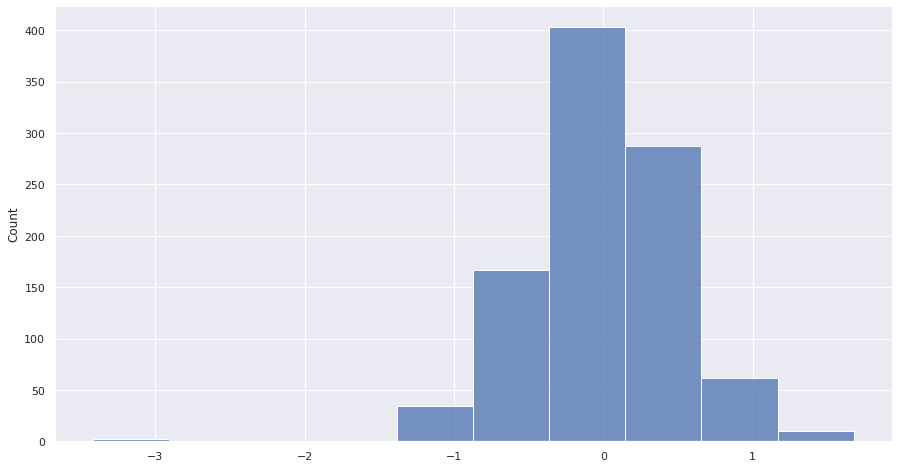

In [52]:
# Residuales
sns.histplot(ml_results.resid, bins=10)

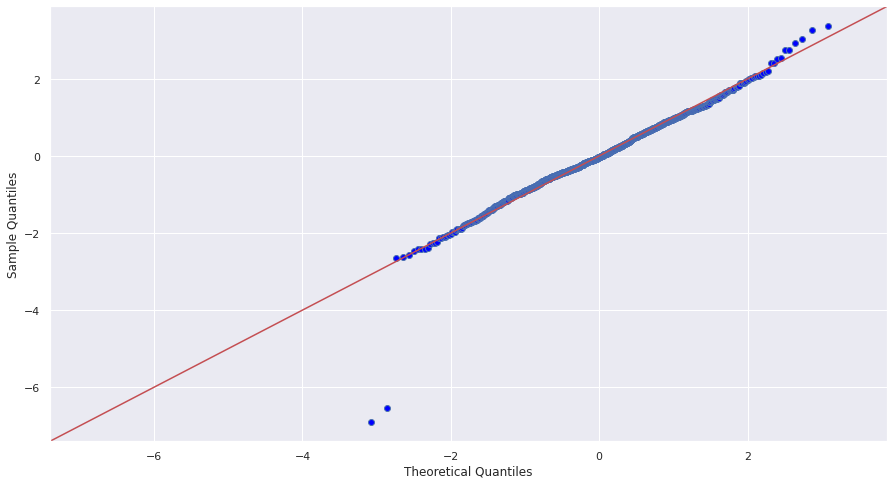

In [53]:
def grafico_qqplot():
    fig = sm.qqplot(lm_resid_stand,line='45')
    plt.show()

grafico_qqplot()

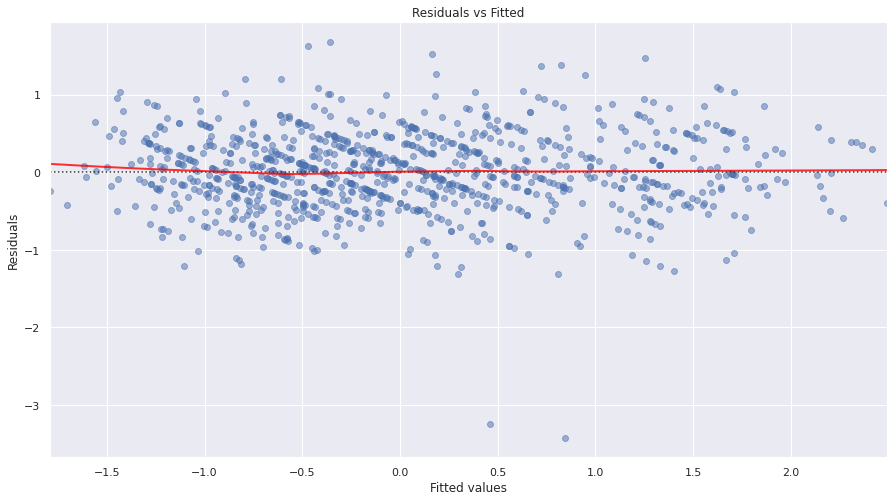

In [54]:
def residuales_vs_ajustados():
    plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                         scatter_kws={'alpha': 0.5},
                         line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

    # Titel and labels
    plot.set_title('Residuals vs Fitted')
    plot.set_xlabel('Fitted values')
    plot.set_ylabel('Residuals')
residuales_vs_ajustados()